In [5]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment140:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2477%2F4140%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T170054Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0da994c41af66871a02f4a3eb54e3fe6cf26f1627afdf189907e20cdee0b4cbf3135eb538f38e6b49ea3bd95f18c034ff3cb0187d0e88779725c7c66a03887aaa5691b6240e00e172e2e25e72c694f5a0fbddc318661ae219bd552007a1aff2b781fe841a50b6d53624d4f04badbb4c5a4e849f3f80df4b812344a096c78ade315bf1ceb20eed255e0515ae2bdb6d9a7ded2b54cd8a008a629990d67afff3ae701590e919591fa0ca90f4607c32598b81cf24d1086404deae1dce3d4e772551f629df4a8f5ceb1b718f46536fa3ec05ec3618238b8416d695954de3303525c163059c76069b63cfe04528f674968d4e405dcad73f22fa90bdf2a8ba4a702d402,contractions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F697638%2F1220322%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T170054Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D88448cee4cb23bcef149a9f2283d9929f2dd6464399b6eda2badd87f915fa18e430e22f4bbcf3f802a00020836f9341bd9c4ac753a107a0c4b5e85910b5d22b07bb6629bf04825598b0780b2fb78426875bd9f8778ee02b15fb6ac5d1e1078df05b056c5047978d813fc22c51a0785f99a140ee769ab01e3db35264bb8ff699e0a4bc4d1f39ba5b0f2f0b24303b65e5d3e6317b28f239394b03857773b4bc1fac9cc46cae7f997375a91093838cc13a3b9d122b3acd0d97f96e52be433363715ebabc44c35d0d01fac6bb1187ef3288be0010d6ec2ff0300f3ef3fd8e1cd17194127a64e6b020bceed27af8f4a39917d469df18d8862cca14e91e571e3839ca0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 84855679 bytes downloaded
Downloaded and uncompressed: sentiment140
[==================================================] 1080 bytes downloaded
Downloaded and uncompressed: contractions
Data source import complete.


# Sentiment Analysis Using Various ML Classifiers ans well as using Recurrent Neural Network

### In this notebook you will see text precessing on twitter data set and after that I have performed different Machine Learning Algorithms on the data such as **Logistic Regression, RandomForestClassifier, SVC, Naive Bayes** to classifiy positive and negative tweets. After that I have also built a RNN network which is the best fit for such textual sentiment analysis, since it's a Sequential Dataset which is requirement for RNN network.

#### Let's Dive into it.

# Index

* <a href="#1" style="color: blue;">Importing Libraries</a>
* <a href="#2" style="color: blue;">Loading Dataset</a>
* <a href="#3" style="color: blue;">Data Visualization</a>
* <a href="#4" style="color: blue;">Data Preprocessing</a>
* <a href="#5" style="color: blue;">Analyzing the Data</a>
* <a href="#6" style="color: blue;">Vectorization and Splitting the data</a>
* <a href="#7" style="color: blue;">Model Building</a>
* <a href="#8" style="color: blue;">Logistic Regression</a>
* <a href="#9" style="color: blue;">Linear SVM</a>
* <a href="#10" style="color: blue;">Random Forest</a>
* <a href="#11" style="color: blue;">Naive Bayes</a>
* <a href="#12" style="color: blue;">RNN</a>
* <a href="#13" style="color: blue;">Model Saving, Loading and Prediction</a>

# Importing libraries <a id="1"></a>

In [ ]:
# DataFrame
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tensorflow as tf

# Utility
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle


from tensorflow.keras.preprocessing import sequence
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input,Embedding,Dropout,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization,SimpleRNN,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

#!pip install keras

#from keras.models import Sequential
#from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences


# Loading Dataset <a id="2"></a>

In [ ]:
# Construct a tf.data.Dataset
data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin', names = ['polarity','id','date','query','user','text'])

In [ ]:
data = data.sample(frac=1)
data = data[:200000]

# Data Visualization <a id="3"></a>

Dataset details
target: the polarity of the tweet (0 = negative, 4 = positive)

* date : the date of the tweet (Sat May 16 23:58:44 PDT 2009)
* polarity : the polarity of the tweet (0 = negative 4 = positive)
* user : the user that tweeted (TerraScene)
* text : the text of the tweet

In [ ]:
print("Dataset shape:", data.shape)

Dataset shape: (200000, 6)


In [ ]:
data.head(10)

,polarity,id,date,query,user,text
1267481,4,1999855931,Mon Jun 01 20:56:59 PDT 2009,NO_QUERY,eyycaiiit,"Bedtime, up at 6:30 (UGH) to go play mommy for..."
1263731,4,1999098452,Mon Jun 01 19:38:21 PDT 2009,NO_QUERY,xmiyix,"If someone deserves a beating, then give it to..."
1318042,4,2014330429,Wed Jun 03 01:10:25 PDT 2009,NO_QUERY,ASOS_Nat,Morning all. Anyone watch &quot;Mary Queen of ...
913964,4,1752749648,Sat May 09 22:51:48 PDT 2009,NO_QUERY,DNACowboy,"@Stacina I have no doubt, darlin'! Just wish ..."
1147181,4,1978039168,Sat May 30 22:17:21 PDT 2009,NO_QUERY,theregos,What a finale to Britain's Got Talent!
1571484,4,2188771326,Mon Jun 15 22:31:52 PDT 2009,NO_QUERY,Muzachan,@osiodhachan Thank you Another beautiful phot...
1453784,4,2063262732,Sun Jun 07 01:58:13 PDT 2009,NO_QUERY,NatashaCit,@silviatan whaat dreamm???
105189,0,1822901126,Sat May 16 20:39:00 PDT 2009,NO_QUERY,kerriehartnett,hope alex is okayyy taylors probably freaking...
101570,0,1794501633,Thu May 14 05:57:35 PDT 2009,NO_QUERY,MrNathanWilliam,think i should head to bed eww 9am prac in the...
1175936,4,1981175042,Sun May 31 08:35:13 PDT 2009,NO_QUERY,THe_RuGGeD_MaN,@strawberry2688 im chillinnn i just woke up w...


In [ ]:
data['polarity'].unique()

array([4, 0])

In [ ]:
# Replacing the value 4 -->1 for ease of understanding.
data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
1267481,1,1999855931,Mon Jun 01 20:56:59 PDT 2009,NO_QUERY,eyycaiiit,"Bedtime, up at 6:30 (UGH) to go play mommy for..."
1263731,1,1999098452,Mon Jun 01 19:38:21 PDT 2009,NO_QUERY,xmiyix,"If someone deserves a beating, then give it to..."
1318042,1,2014330429,Wed Jun 03 01:10:25 PDT 2009,NO_QUERY,ASOS_Nat,Morning all. Anyone watch &quot;Mary Queen of ...
913964,1,1752749648,Sat May 09 22:51:48 PDT 2009,NO_QUERY,DNACowboy,"@Stacina I have no doubt, darlin'! Just wish ..."
1147181,1,1978039168,Sat May 30 22:17:21 PDT 2009,NO_QUERY,theregos,What a finale to Britain's Got Talent!


In [ ]:
data.describe()

,polarity,id
count,200000.000000,2.000000e+05
mean,0.502695,1.998641e+09
std,0.499994,1.934015e+08
min,0.000000,1.467814e+09
25%,0.000000,1.956848e+09
50%,1.000000,2.002159e+09
75%,1.000000,2.176896e+09
max,1.000000,2.329206e+09


In [ ]:
# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity == 1 ]
negatives = data['polarity'][data.polarity == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         200000
No. of positve tagged sentences is:  100539
No. of negative tagged sentences is: 99461


In [ ]:
# get a word count per of text
def word_count(words):
    return len(words.split())

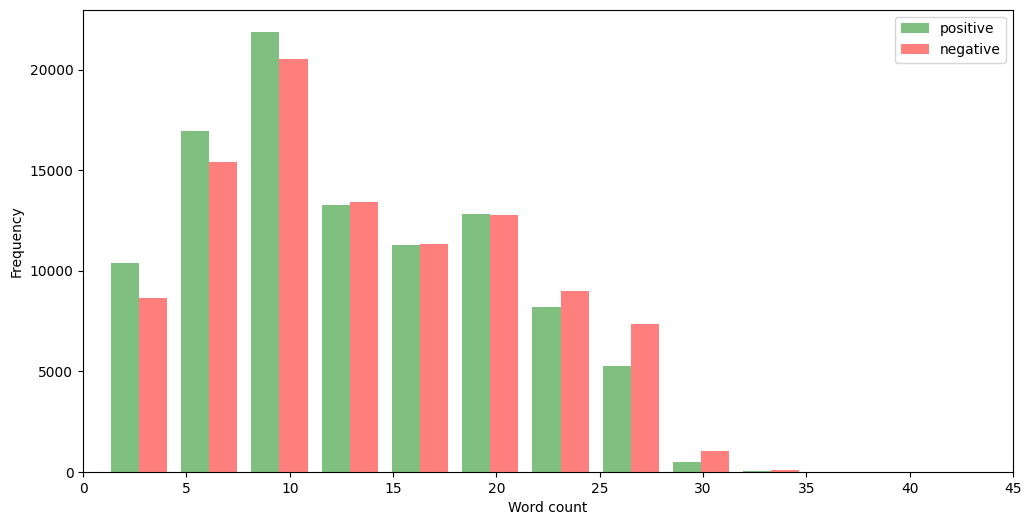

In [ ]:
# plot word count distribution for both positive and negative

data['word count'] = data['text'].apply(word_count)
p = data['word count'][data.polarity == 1]
n = data['word count'][data.polarity == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [ ]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())


Counter(all_words).most_common(20)

[('the', 64959),
 ('and', 36914),
 ('you', 29651),
 ('for', 26964),
 ('have', 17951),
 ('that', 16017),
 ("i'm", 15952),
 ('but', 15721),
 ('just', 15556),
 ('with', 14175),
 ('was', 12825),
 ('not', 12703),
 ('this', 10976),
 ('get', 9979),
 ('good', 9765),
 ('are', 9545),
 ('like', 9460),
 ('all', 9086),
 ('out', 8518),
 ('your', 8208)]

# Data Processing <a id="4"></a>

In [ ]:
# %matplotlib inline
# sns.countplot(data['polarity'])

In [ ]:
# Removing the unnecessary columns.
data.drop(['date','query','user','word count'], axis=1, inplace=True)

In [ ]:
data.drop('id', axis=1, inplace=True)

In [ ]:
data.head(10)

,polarity,text
1267481,1,"Bedtime, up at 6:30 (UGH) to go play mommy for..."
1263731,1,"If someone deserves a beating, then give it to..."
1318042,1,Morning all. Anyone watch &quot;Mary Queen of ...
913964,1,"@Stacina I have no doubt, darlin'! Just wish ..."
1147181,1,What a finale to Britain's Got Talent!
1571484,1,@osiodhachan Thank you Another beautiful phot...
1453784,1,@silviatan whaat dreamm???
105189,0,hope alex is okayyy taylors probably freaking...
101570,0,think i should head to bed eww 9am prac in the...
1175936,1,@strawberry2688 im chillinnn i just woke up w...


In [ ]:
#Checking if any null values present
(data.isnull().sum() / len(data))*100

polarity    0.0
text        0.0
dtype: float64

In [ ]:
#convrting pandas object to a string type
data['text'] = data['text'].astype('str')

In [ ]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

{'isn', 'up', 'while', "won't", 'about', 'so', 'by', 'more', 't', 'during', 'a', 'couldn', 'in', 'most', 'nor', 'me', 'under', 'and', 'herself', "didn't", 'her', 'between', "doesn't", 'not', 'are', 'were', 'being', 'needn', "it's", 'shan', 'was', 'through', 'it', "wasn't", "you'd", 'ain', 'should', "hadn't", 'my', 'after', 'd', "mustn't", 'itself', 'you', 'whom', 'that', 'she', 'because', 'didn', 'wouldn', 'aren', 'had', 'o', 'where', 'once', 'doesn', 'at', 'y', 'over', 'what', 'all', 'we', 'if', "needn't", 'off', 'do', "shouldn't", 'any', 'they', 'will', 'them', 'i', 'down', 'ma', 'shouldn', "isn't", "that'll", 're', 'some', 'be', 'been', 'theirs', 'again', 'hadn', 's', 'doing', 'he', 'hers', 'this', 'of', 'into', "hasn't", 'own', 'further', 'few', "mightn't", 'won', 'than', 'which', "shan't", "she's", 'with', 'having', 'ours', 'on', 'those', 'here', 'don', 'himself', "wouldn't", 've', 'his', 'how', 'have', 'wasn', 'am', 'but', 'an', 'haven', 'same', 'such', 'too', 'other', "couldn't"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

> The Preprocessing steps taken are:

* Lower Casing: Each text is converted to lowercase.
* Removing URLs: Links starting with "http" or "https" or "www" are replaced by "".

* Removing Usernames: Replace @Usernames with word "". (eg: "@XYZ" to "")
* Removing Short Words: Words with length less than 2 are removed.
* Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
* Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)

In [ ]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet)
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [ ]:
import re
import string

# Regular expressions for URL and username patterns
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern = '@[^\s]+'

# Stopwords list
stopwords = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'])

def lowercasing(tweet):
    return tweet.lower()

def remove_urls(tweet):
    return re.sub(urlPattern, '', tweet)

def remove_usernames(tweet):
    return re.sub(userPattern, '', tweet)

def remove_punctuations(tweet):
    return tweet.translate(str.maketrans("", "", string.punctuation))

def tokenize_words(tweet):
    return tweet.split()

def remove_stopwords(tokens):
    return [w for w in tokens if w not in stopwords]

def lemmatize_words(tokens):
    return tokens

def process_tweets(tweet):
    tweet = lowercasing(tweet)
    tweet = remove_urls(tweet)
    tweet = remove_usernames(tweet)
    tweet = remove_punctuations(tweet)
    tokens = tokenize_words(tweet)
    tokens = remove_stopwords(tokens)
    finalwords = lemmatize_words(tokens)
    return ' '.join(finalwords)


In [ ]:
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [ ]:
data.head(10)

,polarity,text,processed_tweets
1267481,1,"Bedtime, up at 6:30 (UGH) to go play mommy for...",bedtime 630 ugh go play mommy enrollsorientate...
1263731,1,"If someone deserves a beating, then give it to...",someone deserves beating give embut still lets...
1318042,1,Morning all. Anyone watch &quot;Mary Queen of ...,morning anyone watch quotmary queen charity sh...
913964,1,"@Stacina I have no doubt, darlin'! Just wish ...",doubt darlin wish could find boy worthy youre ...
1147181,1,What a finale to Britain's Got Talent!,finale britains got talent
1571484,1,@osiodhachan Thank you Another beautiful phot...,thank another beautiful photo pilgrim forest r...
1453784,1,@silviatan whaat dreamm???,whaat dreamm
105189,0,hope alex is okayyy taylors probably freaking...,hope alex okayyy taylors probably freaking
101570,0,think i should head to bed eww 9am prac in the...,think head bed eww 9am prac morning test assig...
1175936,1,@strawberry2688 im chillinnn i just woke up w...,im chillinnn woke u


# Analyzing the data <a id="5"></a>

> #### Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot Word Clouds for Positive and Negative tweets from our dataset and see which words occur the most.

### Word-Cloud for Negative tweets.

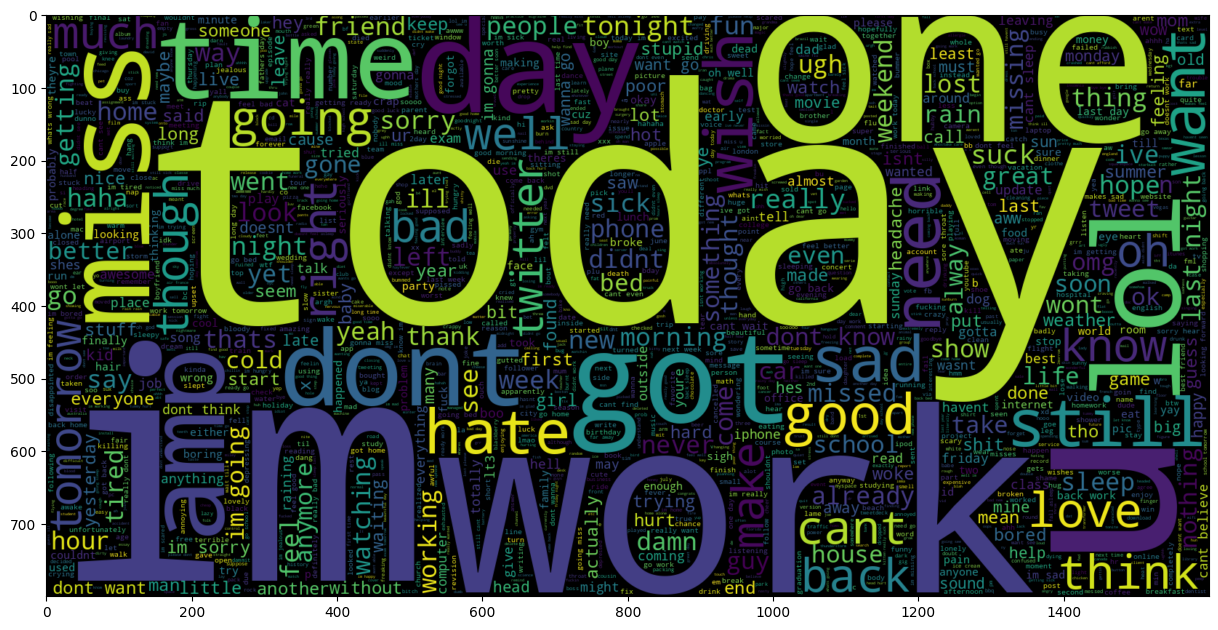

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 0].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

### Word-Cloud for Positive tweets.

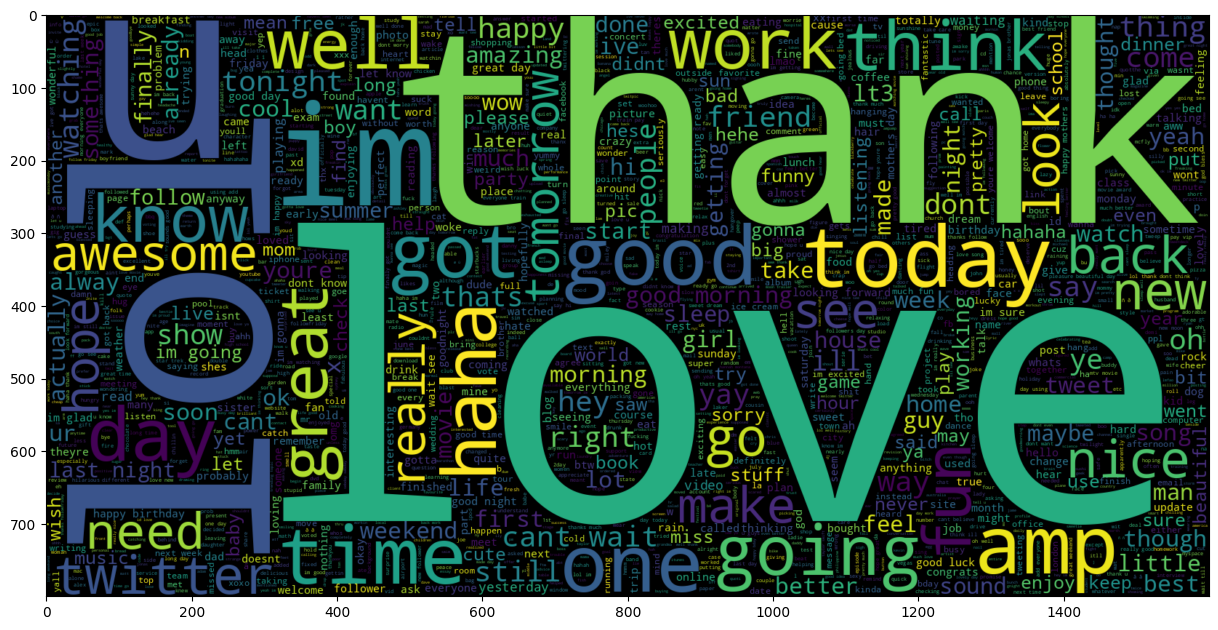

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 1].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

## Vectorization and Splitting the data <a id="6"></a>
Storing input variable-processes_tweets to X and output variable-polarity to y

In [ ]:
X = data['processed_tweets'].values
y = data['polarity'].values


In [ ]:
print(X.shape)
print(y.shape)

(200000,)
(200000,)


## Convert text to word frequency vectors
### TF-IDF
 This is an acronym than stands for **Term Frequency – Inverse Document** Frequency which are the components of the resulting scores assigned to each word.

* Term Frequency: This summarizes how often a given word appears within a document.
* Inverse Document Frequency: This downscales words that appear a lot across documents.

In [ ]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
#print('No. of feature_words: ', len(vector.get_feature_names()))

print('No. of feature_words: ', len(vector.get_feature_names_out()))

Vector fitted.
No. of feature_words:  107450


In [ ]:
print(X.shape)
print(y.shape)

(200000, 107450)
(200000,)


## Split train and test

The Preprocessed Data is divided into 2 sets of data:

* Training Data: The dataset upon which the model would be trained on. Contains 80% data.
* Test Data: The dataset upon which the model would be tested against. Contains 20% data.




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 106726)
y_train (160000,)

X_test (40000, 106726)
y_test (40000,)


# Model Building <a id="7"></a>

### Model evaluating function

In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)

    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Logistic Regression <a id="8"></a>

> Add blockquote



Accuracy of model on training data : 82.248125
Accuracy of model on testing data : 77.2375 

              precision    recall  f1-score   support

           0       0.78      0.75      0.77     19954
           1       0.76      0.79      0.78     20046

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



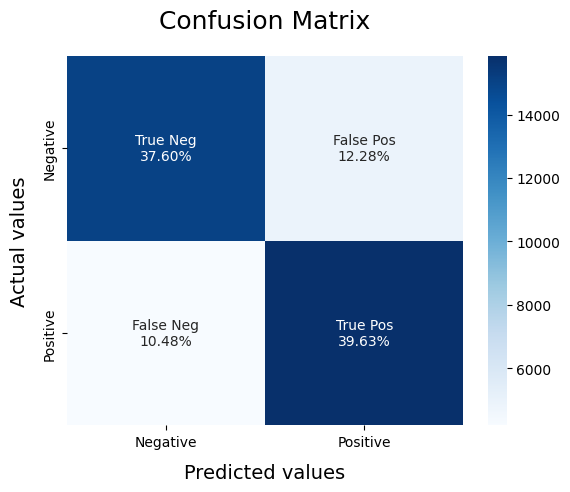

In [ ]:
lg = LogisticRegression()
history=lg.fit(X_train, y_train)
model_Evaluate(lg)

### Linear SVM <a id="9"></a>

Accuracy of model on training data : 88.644375
Accuracy of model on testing data : 75.7 

              precision    recall  f1-score   support

           0       0.76      0.74      0.75     19954
           1       0.75      0.77      0.76     20046

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



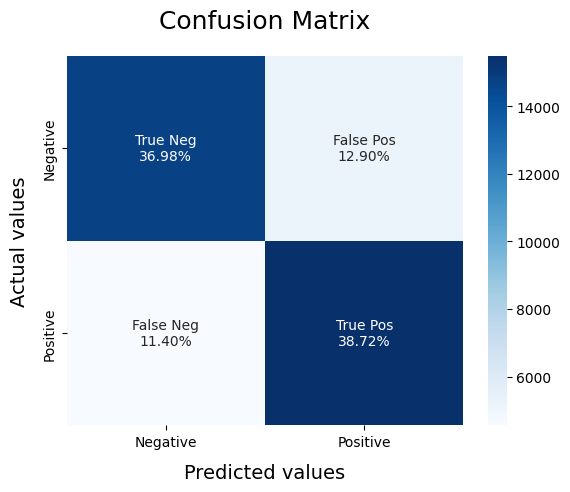

In [ ]:
svm = LinearSVC()
svm.fit(X_train, y_train)
model_Evaluate(svm)

### Random Forest <a id="10"></a>

Accuracy of model on training data : 76.223125
Accuracy of model on testing data : 71.7775 

              precision    recall  f1-score   support

           0       0.75      0.64      0.69     19954
           1       0.69      0.79      0.74     20046

    accuracy                           0.72     40000
   macro avg       0.72      0.72      0.72     40000
weighted avg       0.72      0.72      0.72     40000



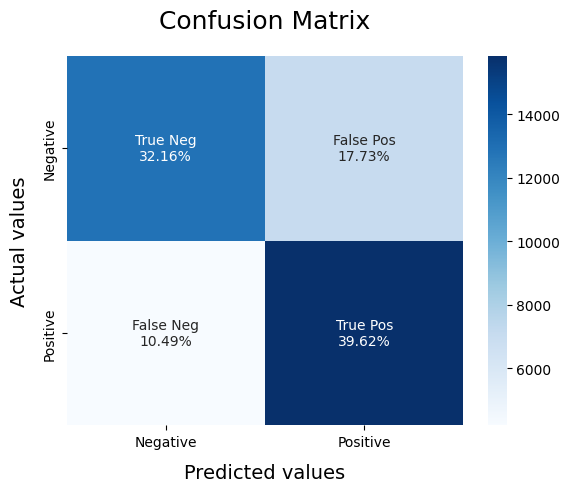

In [ ]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)

### Naive Bayes <a id="11"></a>

Accuracy of model on training data : 83.7575
Accuracy of model on testing data : 75.85499999999999 

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     19954
           1       0.76      0.76      0.76     20046

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



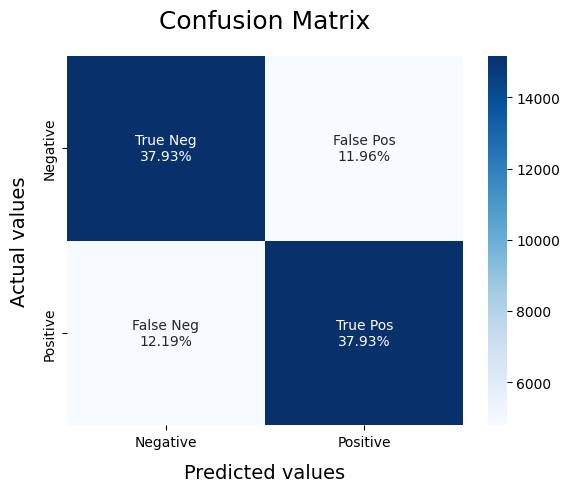

In [ ]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)

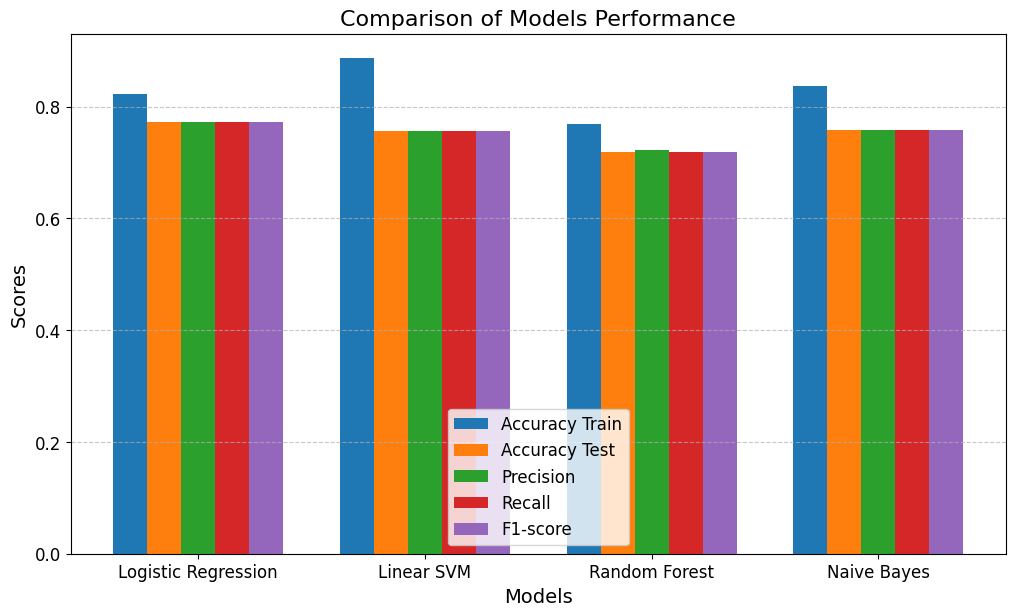

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def model_evaluate(model, X_train, y_train, X_test, y_test):
    acc_train = model.score(X_train, y_train)
    acc_test = model.score(X_test, y_test)

    y_pred = model.predict(X_test)

    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    return {
        "Accuracy Train": acc_train,
        "Accuracy Test": acc_test,
        "Precision": precision,
        "Recall": recall,
        "F1-score": fscore
    }

# Collect evaluation metrics for each model
evaluation_metrics = {}

lg = LogisticRegression()
lg_history = lg.fit(X_train, y_train)
evaluation_metrics['Logistic Regression'] = model_evaluate(lg, X_train, y_train, X_test, y_test)

svm = LinearSVC()
svm.fit(X_train, y_train)
evaluation_metrics['Linear SVM'] = model_evaluate(svm, X_train, y_train, X_test, y_test)

rf = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=50)
rf.fit(X_train, y_train)
evaluation_metrics['Random Forest'] = model_evaluate(rf, X_train, y_train, X_test, y_test)

nb = BernoulliNB()
nb.fit(X_train, y_train)
evaluation_metrics['Naive Bayes'] = model_evaluate(nb, X_train, y_train, X_test, y_test)

# Plotting the bar graph
metrics_names = list(list(evaluation_metrics.values())[0].keys())
models = list(evaluation_metrics.keys())

plt.figure(figsize=(14, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

bar_width = 0.15
index = np.arange(len(models))

for i, metric_name in enumerate(metrics_names):
    metric_values = [metrics[metric_name] for metrics in evaluation_metrics.values()]
    plt.bar(index + i * bar_width, metric_values, bar_width, label=metric_name, color=colors[i])

plt.xlabel('Models', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Comparison of Models Performance', fontsize=16)
plt.xticks(index + 0.3, models, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Adjust the size of the plot by specifying the width and height in inches
plt.gcf().set_size_inches(10, 6)

plt.show()

# RNN <a id="12"></a>

#### What is RNN?
Recurrent neural networks (RNN) are the state of the art algorithm for sequential data and are used by Apple's Siri and and Google's voice search. It is the first algorithm that remembers its input, due to an internal memory, which makes it perfectly suited for machine learning problems that involve sequential data

#### Embedding Layer
Embedding layer is one of the available layers in Keras. This is mainly used in Natural Language Processing related applications such as language modeling, but it can also be used with other tasks that involve neural networks. While dealing with NLP problems, we can use pre-trained word embeddings such as GloVe. Alternatively we can also train our own embeddings using Keras embedding layer.

#### LSTM layer
Long Short Term Memory networks, usually called “LSTMs” , were introduced by Hochreiter and Schmiduber. These have widely been used for speech recognition, language modeling, sentiment analysis and text prediction. Before going deep into LSTM, we should first understand the need of LSTM which can be explained by the drawback of practical use of Recurrent Neural Network (RNN). So, lets start with RNN.

LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
#from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical

import re

In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.processed_tweets)
sequences = tokenizer.texts_to_sequences(data.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)


[[   0    0    0 ...    6  205 1017]
 [   0    0    0 ...  345   86  395]
 [   0    0    0 ...  585  323  127]
 ...
 [   0    0    0 ...    5  207   34]
 [   0    0    0 ... 1716 1220 1826]
 [   0    0    0 ... 1089   28 1965]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data.polarity.values, test_size=0.2, random_state=101)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
#checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)
checkpoint2 = ModelCheckpoint("rnn_model.hdf5",
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='auto')

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint2])



Epoch 1/10
5000/5000 [==============================] - ETA: 0s - loss: 0.5019 - accuracy: 0.7519
Epoch 1: val_accuracy improved from -inf to 0.76695, saving model to rnn_model.hdf5
5000/5000 [==============================] - 675s 134ms/step - loss: 0.5019 - accuracy: 0.7519 - val_loss: 0.4797 - val_accuracy: 0.7670
Epoch 2/10
5000/5000 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.7791
Epoch 2: val_accuracy improved from 0.76695 to 0.76963, saving model to rnn_model.hdf5
5000/5000 [==============================] - 670s 134ms/step - loss: 0.4615 - accuracy: 0.7791 - val_loss: 0.4768 - val_accuracy: 0.7696
Epoch 3/10
5000/5000 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.7887
Epoch 3: val_accuracy improved from 0.76963 to 0.77148, saving model to rnn_model.hdf5
5000/5000 [==============================] - 671s 134ms/step - loss: 0.4450 - accuracy: 0.7887 - val_loss: 0.4727 - val_accuracy: 0.7715
Epoch 4/10
5000/5000 [===============

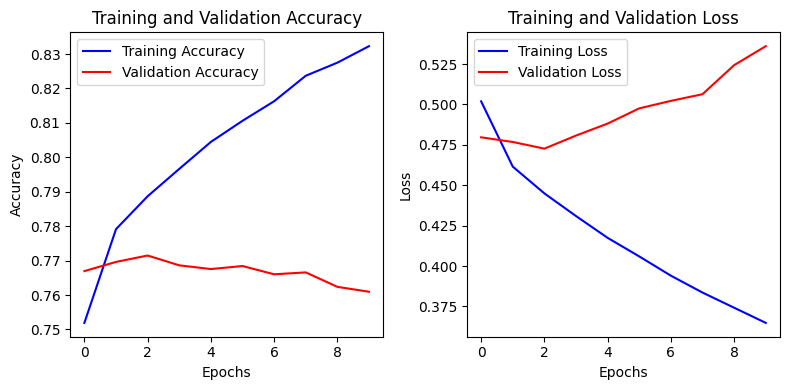

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(8, 4))  # Set smaller figure size

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1250/1250 [==============================] - 41s 33ms/step
              precision    recall  f1-score   support

           0       0.77      0.74      0.76     19960
           1       0.75      0.78      0.77     20040

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



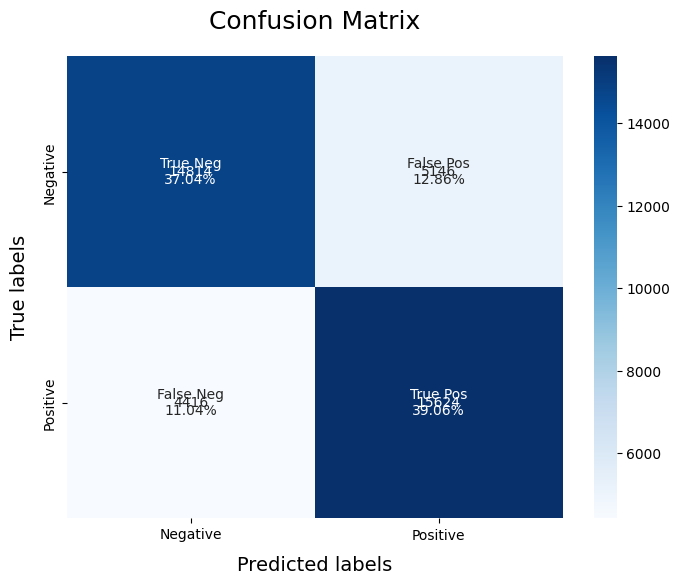

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities for the test data
y_pred_prob = model2.predict(X_test)

# Binarize probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)

categories = ['Negative', 'Positive']
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(conf_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)

plt.xlabel('Predicted labels', fontdict={'size': 14}, labelpad=10)
plt.ylabel('True labels', fontdict={'size': 14}, labelpad=10)
plt.title('Confusion Matrix', fontdict={'size': 18}, pad=20)

plt.show()


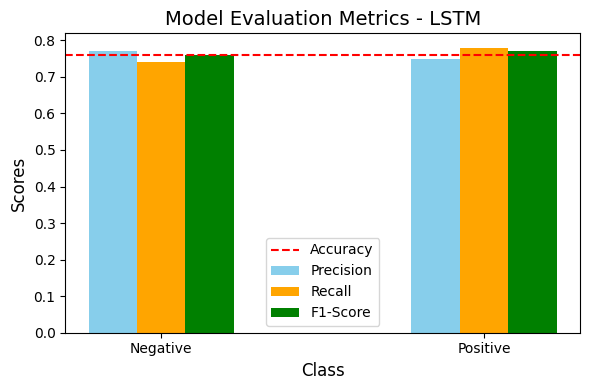

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parse the classification report
classification_report = """
              precision    recall  f1-score   support

           0       0.77      0.74      0.76     19960
           1       0.75      0.78      0.77     20040

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000
"""

# Extract accuracy, precision, recall, and F1-score from the classification report
accuracy = 0.76
precision = [0.77, 0.75]
recall = [0.74, 0.78]
f1_score = [0.76, 0.77]

# Set the width of the bars
bar_width = 0.15
index = np.arange(len(precision))

# Plotting the grouped bar chart
plt.figure(figsize=(6, 4))  # Adjust the figure size here

plt.bar(index, precision, bar_width, color='skyblue', label='Precision')
plt.bar(index + bar_width, recall, bar_width, color='orange', label='Recall')
plt.bar(index + 2 * bar_width, f1_score, bar_width, color='green', label='F1-Score')
plt.axhline(y=accuracy, color='red', linestyle='--', label='Accuracy')  # Plot accuracy as a horizontal line

plt.xlabel('Class', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Model Evaluation Metrics - LSTM', fontsize=14)  # Add the model name to the title
plt.xticks(index + bar_width, ['Negative', 'Positive'])
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
sequence = tokenizer.texts_to_sequences(['this data science article is the worst ever'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model2.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')
# print(pred)

1/1 [==============================] - 0s 469ms/step
Negative


In [ ]:
model = keras.models.load_model('rnn_model.hdf5')
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

1/1 [==============================] - 0s 480ms/step
Positive


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Example data
texts = ['I had a bad day at work.', 'I love my job!']

# Tokenize texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Define a simple LSTM model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now, you can use the model for prediction
sequence = tokenizer.texts_to_sequences(['I had a bad day at work.'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)

if pred > 0.5:
    print('Positive')
else:
    print('Negative')


1/1 [==============================] - 1s 710ms/step
Positive


# Model Saving, Loading and Prediction <a id="13"></a>

In [ ]:
import pickle

file = open('vectoriser.pickle','wb')
pickle.dump(vector, file)
file.close()

file = open('logisticRegression.pickle','wb')
pickle.dump(lg, file)
file.close()

file = open('SVM.pickle','wb')
pickle.dump(svm, file)
file.close()

file = open('RandomForest.pickle','wb')
pickle.dump(rf, file)
file.close()

file = open('NaivesBayes.pickle','wb')
pickle.dump(nb, file)
file.close()

NameError: name 'lg' is not defined

### Predict using saved model

In [ ]:
def load_models():
    # Load the vectoriser.
    file = open('vectoriser.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('logisticRegression.pickle', 'rb')
    lg = pickle.load(file)
    file.close()
    return vectoriser, lg

In [ ]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    processes_text=[process_tweets(sen) for sen in text]
    textdata = vectoriser.transform(processes_text)
    sentiment = model.predict(textdata)

    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [ ]:
if __name__=="__main__":
    # Loading the models.
    vectoriser, lg = load_models()

    # Text to classify should be in a list.
    text = ["I love machine learning",
            "Work is too hectic.",
            "Mr.Sharama, I feel so good"]

    df = predict(vectoriser, lg, text)
    print(df.head())


                         text sentiment
0     I love machine learning  Positive
1         Work is too hectic.  Negative
2  Mr.Sharama, I feel so good  Negative


###### CNN-LSTM Model

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contractions/contractions.csv
/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import tensorflow as tf
from nltk.corpus import stopwords
import keras.backend as K
from keras.models import Sequential
import string
import re

from tensorflow.keras.preprocessing import sequence
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input,Embedding,Dropout,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization,SimpleRNN,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#import transformers
#import tokenizers

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import pipeline

from sklearn.metrics import accuracy_score
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
print('length of data is', len(data))

length of data is 1600000


In [ ]:
data.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
data.target.value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [ ]:
data['target'] = data['target'].replace(4,1)
data=data[['text','target']]
data.target.value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [ ]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s

data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()
data['text'] = data['text'].apply(clean_text)

In [ ]:
#Train test split
x=data.text
y=data.target

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y,
    test_size=0.05, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
    test_size=0.2, random_state= 8)

In [ ]:
#tokenize
max_features = 40000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#sequencing for lstm
max_words = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_words, padding = 'post')
X_val = sequence.pad_sequences(X_val, maxlen=max_words, padding = 'post')
X_test = sequence.pad_sequences(X_test, maxlen=max_words, padding = 'post')

In [ ]:
#Evaluating proper format and shape
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(X_train.shape,X_val.shape, X_test.shape)

(1216000, 100) (304000, 100) (80000, 100)


In [ ]:
model = Sequential()
model.add(Embedding(40000, 10))  # Remove input_length argument
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 10)          400000    
                                                                 
 conv1d (Conv1D)             (None, None, 32)          992       
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 32)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)         

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10, batch_size=256, verbose=1)

Epoch 1/10
4750/4750 [==============================] - 310s 65ms/step - loss: 0.4344 - accuracy: 0.7973 - val_loss: 0.4121 - val_accuracy: 0.8113
Epoch 2/10
4750/4750 [==============================] - 305s 64ms/step - loss: 0.3883 - accuracy: 0.8249 - val_loss: 0.4046 - val_accuracy: 0.8146
Epoch 3/10
4750/4750 [==============================] - 307s 65ms/step - loss: 0.3683 - accuracy: 0.8357 - val_loss: 0.4064 - val_accuracy: 0.8147
Epoch 4/10
4750/4750 [==============================] - 303s 64ms/step - loss: 0.3527 - accuracy: 0.8441 - val_loss: 0.4180 - val_accuracy: 0.8124
Epoch 5/10
4750/4750 [==============================] - 302s 64ms/step - loss: 0.3397 - accuracy: 0.8507 - val_loss: 0.4294 - val_accuracy: 0.8068
Epoch 6/10
4750/4750 [==============================] - 305s 64ms/step - loss: 0.3282 - accuracy: 0.8567 - val_loss: 0.4428 - val_accuracy: 0.8067
Epoch 7/10
4750/4750 [==============================] - 307s 65ms/step - loss: 0.3173 - accuracy: 0.8620 - val_loss: 0

In [ ]:
result = model.evaluate(X_test,y_test)
result

2500/2500 [==============================] - 13s 5ms/step - loss: 0.5039 - accuracy: 0.8015


[0.503905177116394, 0.8014624714851379]

Epoch 1/10
4750/4750 [==============================] - 309s 65ms/step - loss: 0.2854 - accuracy: 0.8767 - val_loss: 0.5306 - val_accuracy: 0.7979
Epoch 2/10
4750/4750 [==============================] - 303s 64ms/step - loss: 0.2797 - accuracy: 0.8793 - val_loss: 0.5307 - val_accuracy: 0.7983
Epoch 3/10
4750/4750 [==============================] - 302s 63ms/step - loss: 0.2745 - accuracy: 0.8815 - val_loss: 0.5669 - val_accuracy: 0.7946
Epoch 4/10
4750/4750 [==============================] - 303s 64ms/step - loss: 0.2697 - accuracy: 0.8834 - val_loss: 0.5842 - val_accuracy: 0.7940
Epoch 5/10
4750/4750 [==============================] - 303s 64ms/step - loss: 0.2656 - accuracy: 0.8854 - val_loss: 0.5652 - val_accuracy: 0.7934
Epoch 6/10
4750/4750 [==============================] - 307s 65ms/step - loss: 0.2616 - accuracy: 0.8871 - val_loss: 0.6010 - val_accuracy: 0.7904
Epoch 7/10
4750/4750 [==============================] - 307s 65ms/step - loss: 0.2583 - accuracy: 0.8886 - val_loss: 0

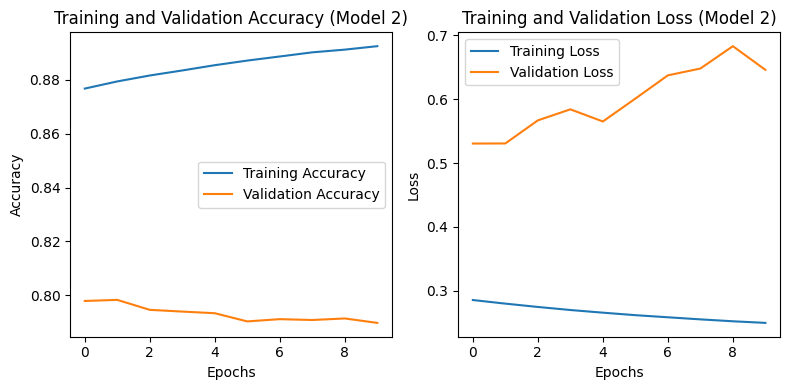

In [ ]:
import matplotlib.pyplot as plt

# Train the second model and collect history
history_model2 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=256, verbose=1)

# Set figure size
plt.figure(figsize=(8, 4))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_model2.history['accuracy'], label='Training Accuracy')
plt.plot(history_model2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Model 2)')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_model2.history['loss'], label='Training Loss')
plt.plot(history_model2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Model 2)')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


2500/2500 [==============================] - 11s 4ms/step
              precision    recall  f1-score   support

           0       0.78      0.81      0.79     40007
           1       0.80      0.77      0.79     39993

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



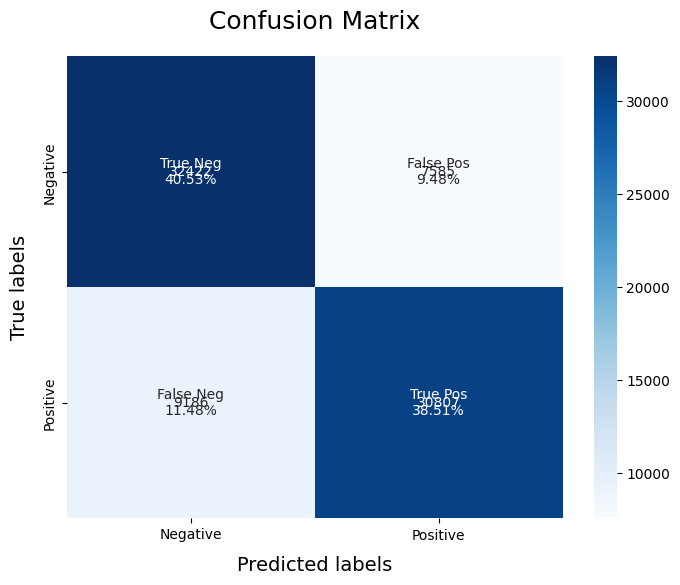

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)

categories = ['Negative', 'Positive']
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(conf_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)

plt.xlabel('Predicted labels', fontdict={'size': 14}, labelpad=10)
plt.ylabel('True labels', fontdict={'size': 14}, labelpad=10)
plt.title('Confusion Matrix', fontdict={'size': 18}, pad=20)

plt.show()


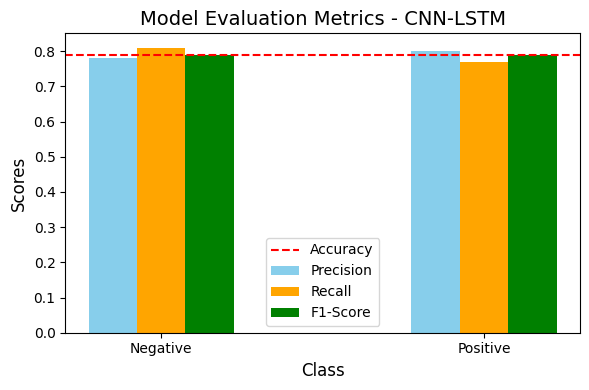

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parse the classification report
classification_report = """
              precision    recall  f1-score   support

           0       0.78      0.81      0.79     40007
           1       0.80      0.77      0.79     39993

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000
"""

# Extract accuracy, precision, recall, and F1-score from the classification report
accuracy = 0.79
precision = [0.78, 0.80]
recall = [0.81, 0.77]
f1_score = [0.79, 0.79]

# Set the width of the bars
bar_width = 0.15
index = np.arange(len(precision))

# Plotting the grouped bar chart
plt.figure(figsize=(6, 4))  # Adjust the figure size here

plt.bar(index, precision, bar_width, color='skyblue', label='Precision')
plt.bar(index + bar_width, recall, bar_width, color='orange', label='Recall')
plt.bar(index + 2 * bar_width, f1_score, bar_width, color='green', label='F1-Score')
plt.axhline(y=accuracy, color='red', linestyle='--', label='Accuracy')  # Plot accuracy as a horizontal line

plt.xlabel('Class', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Model Evaluation Metrics - CNN-LSTM', fontsize=14)  # Add the model name to the title
plt.xticks(index + bar_width, ['Negative', 'Positive'])
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


BiLSTM

In [12]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [13]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)


In [14]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

In [15]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('../input/contractions/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
      tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [16]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 1min 15s, sys: 255 ms, total: 1min 15s
Wall time: 1min 16s


In [17]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <user> <url>   aww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>
Text: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed: is upset that he cannot update his facebook by texting it   and might cry as a result  school today also  blah 
Text: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed: <user> i dived many times for the ball  managed to save 50   the rest go out of bounds
Text: my whole body feels itchy and like its on fire 
Processed: my whole body feels itchy and like its on fire 
Text: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed: <user> no  it is not behaving at all  i am mad  why am i here  because i cannot see you all ov

In [18]:
processedtext = list(dataset['processed_text'])
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [21]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [22]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 52025
CPU times: user 3min 37s, sys: 1.43 s, total: 3min 39s
Wall time: 2min 7s


In [23]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Assuming X_data is your list of texts
X_data = ["your", "list", "of", "texts", "here"]

vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)


Tokenizer vocab length: 60000


In [25]:
X_train_texts = [str(text) for text in X_train]
X_test_texts = [str(text) for text in X_test]

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_texts), maxlen=input_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_texts), maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)


X_train.shape: (1520000, 60)
X_test.shape: (80000, 60)


Creating Embedding Matrix

In [26]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


Creating the Model

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [28]:
def getModel(embedding_matrix):
    embedding_layer = Embedding(input_dim=vocab_length,
                                output_dim=Embedding_dimensions,
                                trainable=False)

    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model


In [29]:
training_model = getModel(embedding_matrix)
training_model.summary()


Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         6000000   
                                                                 
 bidirectional (Bidirection  (None, None, 200)         160800    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 200)         240800    
 onal)                                                           
                                                                 
 conv1d (Conv1D)             (None, None, 100)         100100    
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                   

In [30]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True),
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
]


In [31]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [32]:

history_model3 = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
1336/1336 [==============================] - 173s 119ms/step - loss: 0.6906 - accuracy: 0.5131 - val_loss: 0.6902 - val_accuracy: 0.5149
Epoch 2/12
1336/1336 [==============================] - 157s 117ms/step - loss: 0.6903 - accuracy: 0.5135 - val_loss: 0.6901 - val_accuracy: 0.5149
Epoch 3/12
1336/1336 [==============================] - 156s 117ms/step - loss: 0.6903 - accuracy: 0.5136 - val_loss: 0.6901 - val_accuracy: 0.5149
Epoch 4/12
1336/1336 [==============================] - 156s 117ms/step - loss: 0.6903 - accuracy: 0.5137 - val_loss: 0.6901 - val_accuracy: 0.5149
Epoch 5/12
1336/1336 [==============================] - 155s 116ms/step - loss: 0.6902 - accuracy: 0.5137 - val_loss: 0.6903 - val_accuracy: 0.5149
Epoch 6/12
1336/1336 [==============================] - 154s 115ms/step - loss: 0.6902 - accuracy: 0.5136 - val_loss: 0.6902 - val_accuracy: 0.5149
Epoch 7/12
1336/1336 [==============================] - 152s 114ms/step - loss: 0.6902 - accuracy: 0.5138 - val_

In [2]:
import matplotlib.pyplot as plt

# Extracting accuracy and loss values
acc = history_model3.history['accuracy']
val_acc = history_model3.history['val_accuracy']
loss = history_model3.history['loss']
val_loss = history_model3.history['val_loss']
epochs = range(len(acc))

# Plotting training and validation accuracy
plt.figure(figsize=(8, 4))  # Set smaller figure size
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(8, 4))  # Set smaller figure size
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'history_model3' is not defined

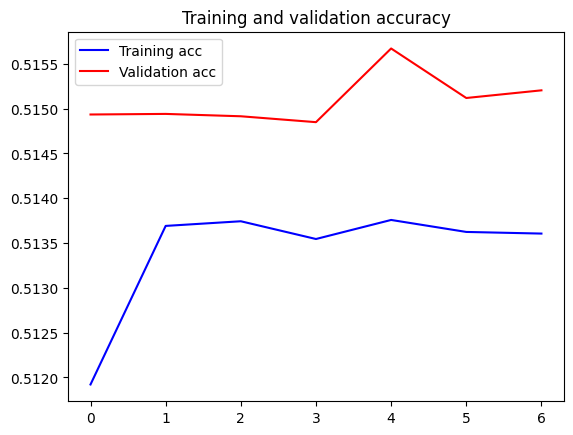

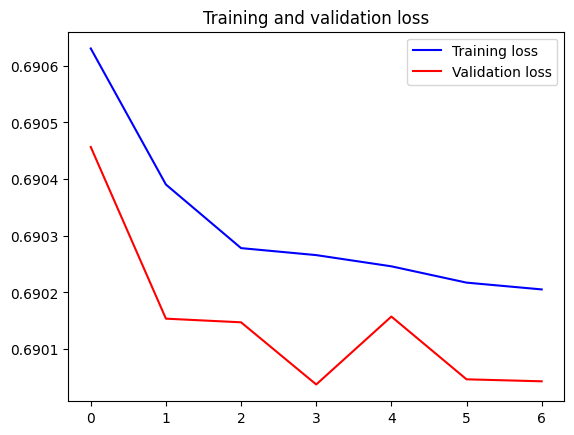

In [ ]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

2500/2500 [==============================] - 19s 7ms/step


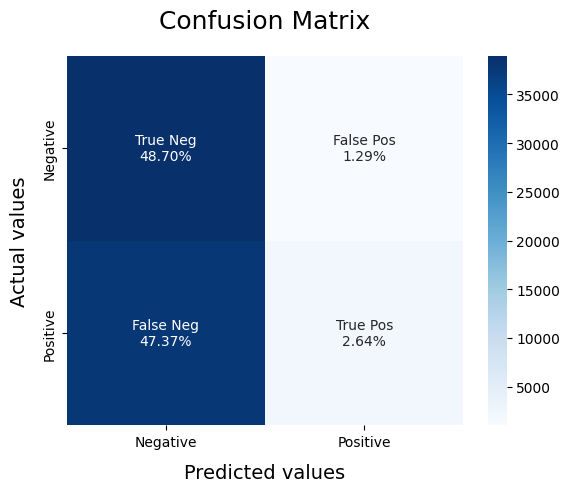

In [ ]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics.
ConfusionMatrix(y_pred, y_test)

In [ ]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.97      0.67     39989
           1       0.67      0.05      0.10     40011

    accuracy                           0.51     80000
   macro avg       0.59      0.51      0.38     80000
weighted avg       0.59      0.51      0.38     80000



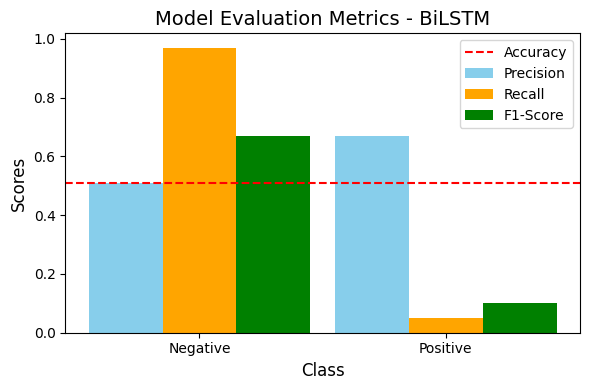

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Parse the classification report
classification_report = """
             precision    recall  f1-score   support

           0       0.51      0.97      0.67     39989
           1       0.67      0.05      0.10     40011

    accuracy                           0.51     80000
   macro avg       0.59      0.51      0.38     80000
weighted avg       0.59      0.51      0.38     80000
"""

# Extract precision, recall, and F1-score from the classification report
precision = [0.51, 0.67]
recall = [0.97, 0.05]
f1_score = [0.67, 0.10]
accuracy = 0.51  # Add accuracy value here

# Set the width of the bars
bar_width = 0.3
index = np.arange(len(precision))

# Plotting the bar chart
plt.figure(figsize=(6, 4))  # Adjust the figure size here

plt.bar(index, precision, bar_width, color='skyblue', label='Precision')
plt.bar(index + bar_width, recall, bar_width, color='orange', label='Recall')
plt.bar(index + 2 * bar_width, f1_score, bar_width, color='green', label='F1-Score')
plt.axhline(y=accuracy, color='red', linestyle='--', label='Accuracy')  # Add horizontal line for accuracy

plt.xlabel('Class', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Model Evaluation Metrics - BiLSTM', fontsize=14)  # Update the title with model name
plt.xticks(index + bar_width, ['Negative', 'Positive'])
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## **`CNN`**

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/contractions/contractions.csv


In [7]:

# Construct a tf.data.Dataset
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',header=None)

df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Feature Engineering

In [8]:
columns=df.columns
columns

Index([0, 1, 2, 3, 4, 5], dtype='int64')

In [9]:
df.drop([1,2,3,4],axis=1,inplace=True)
df.head()

,0,5
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [10]:
df.columns=['sentiment','data']
df.head()

,sentiment,data
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [11]:
y=df['sentiment']

Splitting the dataset in train and test split

In [12]:
from sklearn.model_selection import train_test_split
df_train,df_test,y_train,y_test=train_test_split(df['data'],y,test_size=0.33,random_state=42)
print('DF Train Shape: ',df_train.shape)
print('DF Test Shape: ',df_test.shape)
print('Y Train Shape: ',y_train.shape)
print('Y Test Shape: ',y_test.shape)

DF Train Shape:  (1072000,)
DF Test Shape:  (528000,)
Y Train Shape:  (1072000,)
Y Test Shape:  (528000,)


Building deep learn model

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(df_train)
sequence_train=tokenizer.texts_to_sequences(df_train)
sequence_test=tokenizer.texts_to_sequences(df_test)

In [14]:
word2vec=tokenizer.word_index
V=len(word2vec)
print('dataset has %s number of independent tokens' %V)

dataset has 527470 number of independent tokens


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_train=pad_sequences(sequence_train)
data_train.shape

(1072000, 116)

In [16]:
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)
data_test.shape

(528000, 116)

In [17]:
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model

In [18]:
D=100
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
model=Model(i,x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 116)]             0         
                                                                 
 embedding (Embedding)       (None, 116, 100)          52747100  
                                                                 
 conv1d (Conv1D)             (None, 114, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1  (None, 38, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 12, 64)            0         
 g1D)                                                        

Training the mode

In [19]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=5,batch_size=100)

Epoch 1/5
  653/10720 [>.............................] - ETA: 3:47:29 - loss: 0.5462 - accuracy: 0.7147

KeyboardInterrupt: 

In [ ]:
y_pred=model.predict(data_test)
y_pred

16500/16500 [==============================] - 34s 2ms/step


array([[6.62509501e-01, 1.92352634e-10, 1.24046606e-10, 1.75974152e-10,
        3.37490499e-01],
       [2.21440747e-01, 1.64098665e-18, 6.11671008e-19, 6.85002327e-19,
        7.78559268e-01],
       [5.10207176e-01, 6.71549359e-20, 2.12248729e-20, 1.33089645e-20,
        4.89792794e-01],
       ...,
       [1.59724876e-02, 1.21660674e-20, 3.81148024e-21, 3.27208033e-21,
        9.84027505e-01],
       [5.79559326e-01, 4.67069678e-38, 0.00000000e+00, 0.00000000e+00,
        4.20440704e-01],
       [8.79027069e-01, 6.00801028e-19, 2.74501773e-19, 1.64359534e-19,
        1.20972961e-01]], dtype=float32)

In [ ]:
y_pred=np.argmax(y_pred,axis=1)
y_pred

array([0, 4, 0, ..., 4, 0, 0])

Scoring

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

Text(50.722222222222214, 0.5, 'y_pred')

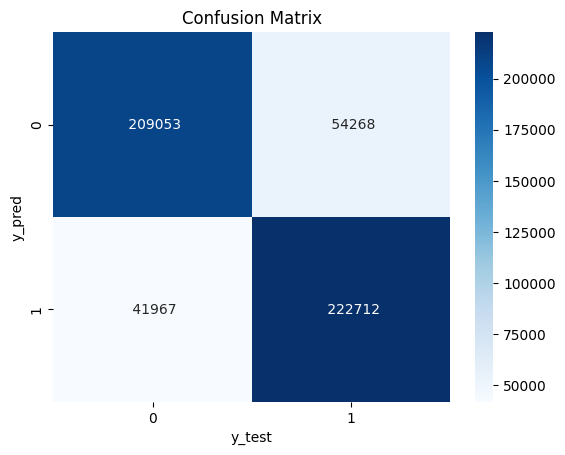

In [ ]:
cm=confusion_matrix(y_test,y_pred)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81    263321
           4       0.80      0.84      0.82    264679

    accuracy                           0.82    528000
   macro avg       0.82      0.82      0.82    528000
weighted avg       0.82      0.82      0.82    528000



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def model_Evaluate(model, X_test, y_test):
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print('Accuracy of model on testing data : {:.2f}%\n'.format(test_accuracy * 100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print the classification report
    print(classification_report(y_test, y_pred_classes))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred_classes)

    categories  = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()


Accuracy of model on testing data : 81.77%

16500/16500 [==============================] - 34s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.79      0.81    263321
           4       0.80      0.84      0.82    264679

    accuracy                           0.82    528000
   macro avg       0.82      0.82      0.82    528000
weighted avg       0.82      0.82      0.82    528000



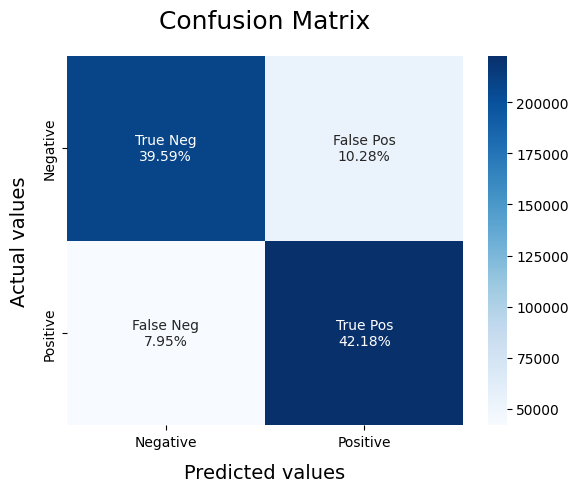

In [ ]:
model_Evaluate(model, data_test, y_test)


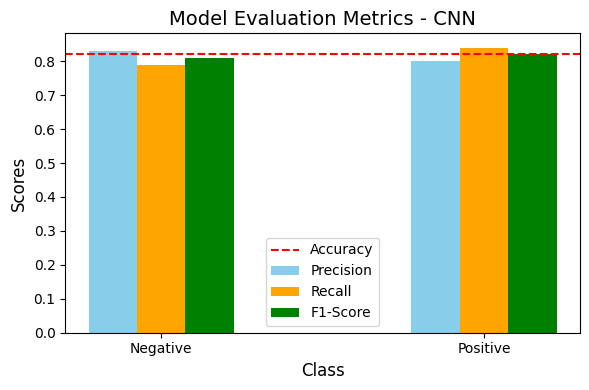

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parse the classification report
classification_report = """
              precision    recall  f1-score   support

           0       0.83      0.79      0.81    263321
           4       0.80      0.84      0.82    264679

    accuracy                           0.82    528000
   macro avg       0.82      0.82      0.82    528000
weighted avg       0.82      0.82      0.82    528000
"""

# Extract accuracy, precision, recall, and F1-score from the classification report
accuracy = 0.82
precision = [0.83, 0.80]
recall = [0.79, 0.84]
f1_score = [0.81, 0.82]

# Set the width of the bars
bar_width = 0.15
index = np.arange(len(precision))

# Plotting the grouped bar chart
plt.figure(figsize=(6, 4))  # Adjust the figure size here

plt.bar(index, precision, bar_width, color='skyblue', label='Precision')
plt.bar(index + bar_width, recall, bar_width, color='orange', label='Recall')
plt.bar(index + 2 * bar_width, f1_score, bar_width, color='green', label='F1-Score')
plt.axhline(y=accuracy, color='red', linestyle='--', label='Accuracy')  # Plot accuracy as a horizontal line

plt.xlabel('Class', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Model Evaluation Metrics - CNN', fontsize=14)  # Add the model name to the title
plt.xticks(index + bar_width, ['Negative', 'Positive'])
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [5]:
!pip install tabulate


In [3]:
from tabulate import tabulate

data = [
    ["Logistic Regression", 77, 77, 77, 77],
    ["SVM", 76, 76, 76, 76],
    ["Random Forest", 72, 72, 72, 72],
    ["Naive Bayes", 76, 76, 76, 76],
    ["LSTM", 76, 76, 76, 76],
    ["CNN-LSTM", 79, 79, 79, 79],
    ["BiLSTM", 84, 84, 84, 84],
    ["CNN", 82, 82, 82, 82]
]

headers = ["Model Name", "Accuracy(%)", "Precision(%)", "Recall(%)", "F1-Score(%)"]

print(tabulate(data, headers=headers, tablefmt="grid"))


+---------------------+---------------+----------------+-------------+---------------+
| Model Name          |   Accuracy(%) |   Precision(%) |   Recall(%) |   F1-Score(%) |
+=====================+===============+================+=============+===============+
| Logistic Regression |            77 |             77 |          77 |            77 |
+---------------------+---------------+----------------+-------------+---------------+
| SVM                 |            76 |             76 |          76 |            76 |
+---------------------+---------------+----------------+-------------+---------------+
| Random Forest       |            72 |             72 |          72 |            72 |
+---------------------+---------------+----------------+-------------+---------------+
| Naive Bayes         |            76 |             76 |          76 |            76 |
+---------------------+---------------+----------------+-------------+---------------+
| LSTM                |            76 |    